In [135]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [136]:
# Set device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Loading training dataset

In [137]:
transform = transforms.ToTensor()
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Poisson rate coding to convert pixel intensities into spike trains

In [138]:
def poisson_encode(images, num_steps, device):
    images = images.view(-1, 784).to(device)
    rand_vals = torch.rand(num_steps, images.shape[0], images.shape[1], device=device)
    return (rand_vals < images).float()

Sample input spike patterns for various digits to verify that encoding is working correctly

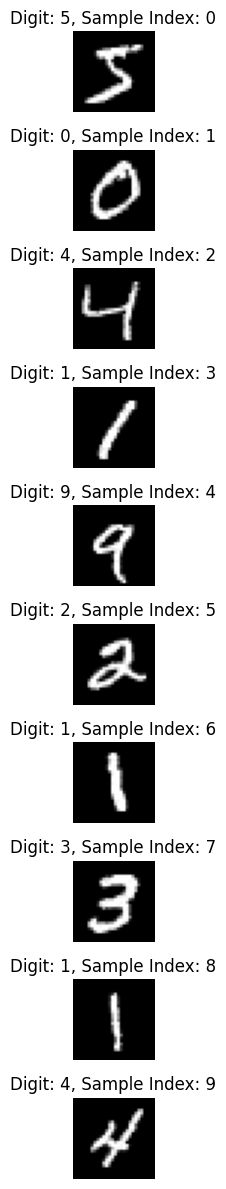

In [139]:
sample_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axs = plt.subplots(len(sample_indices), 1, figsize=(6, 12))

for i, idx in enumerate(sample_indices):
    sample_img, label = trainset[idx]
    sample_img = sample_img.to(device).unsqueeze(0)
    spikes = poisson_encode(sample_img, 25, device) 
    spike_img = spikes[:, 0, :].sum(dim=0).cpu().numpy().reshape(28, 28)
    axs[i].imshow(spike_img, cmap='gray')
    axs[i].set_title(f"Digit: {label}, Sample Index: {idx}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Defining Surrogate Gradient Function

In [140]:
class SurrogateSpike(torch.autograd.Function):
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 1.0).float()
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad = grad_output / (10 * torch.abs(input - 1.0) + 1.0) ** 2
        return grad

Implementation of Leaky Integrate-and-Fire (LIF) neuron model

In [141]:
class LIFLayer(nn.Module):
    def __init__(self, size, tau=2.0):
        super().__init__()
        self.size = size
        self.tau = tau
    
    def forward(self, input, mem):
        # Leaky integration
        mem = mem * (1 - 1/self.tau) + input
        # Generate spikes
        spk = SurrogateSpike.apply(mem)
        # Reset after spike
        mem = mem * (1 - spk)
        return spk, mem

SNN Model Architecture with:
1. Membrane potential dynamics with leakage
2. Threshold-based spike generation
3. Reset mechanism after firing

In [142]:
class SNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=1024, output_size=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.lif1 = LIFLayer(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=True)
        self.lif2 = LIFLayer(output_size)
    
    def forward(self, x_seq):
        batch_size = x_seq.size(1)
        mem1 = torch.zeros(batch_size, self.fc1.out_features, device=device)
        mem2 = torch.zeros(batch_size, self.fc2.out_features, device=device)
        out_spikes = torch.zeros(batch_size, self.fc2.out_features, device=device)
        
        for t in range(x_seq.size(0)):
            x = x_seq[t]
            h = self.fc1(x)
            spk1, mem1 = self.lif1(h, mem1)
            o = self.fc2(spk1)
            spk2, mem2 = self.lif2(o, mem2)
            out_spikes += spk2
        
        return out_spikes / x_seq.size(0)

Model Initialization and Training Setup

In [143]:
model = SNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
num_steps = 25

Training Loop

In [144]:
train_losses = []
train_accuracies = []

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Generate spike trains
        spikes = poisson_encode(images, num_steps, device)

        # Forward pass
        outputs = model(spikes)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = 100 * total_correct / total_samples
    avg_loss = total_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Training Accuracy={train_accuracy:.2f}%")

Epoch 1: Loss=1.5407, Training Accuracy=91.69%
Epoch 2: Loss=1.4951, Training Accuracy=96.37%
Epoch 3: Loss=1.4863, Training Accuracy=97.39%
Epoch 4: Loss=1.4815, Training Accuracy=97.90%
Epoch 5: Loss=1.4789, Training Accuracy=98.25%
Epoch 6: Loss=1.4764, Training Accuracy=98.45%
Epoch 7: Loss=1.4748, Training Accuracy=98.59%
Epoch 8: Loss=1.4736, Training Accuracy=98.80%
Epoch 9: Loss=1.4729, Training Accuracy=98.86%
Epoch 10: Loss=1.4721, Training Accuracy=98.97%


Plots of training curves

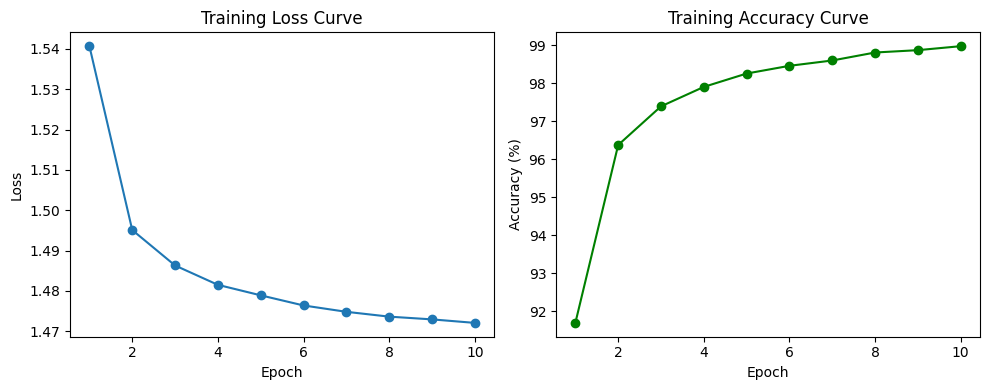

In [149]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')

plt.tight_layout()
plt.show()

Evaluation using Test Accuracy

In [150]:
model.eval()
correct, total = 0, 0

testset = datasets.MNIST('./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        spikes = poisson_encode(images, num_steps, device)
        outputs = model(spikes)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 98.08%


Visualization of Spikes using Spike Raster Plot

Visualizing spikes for sample index: 0


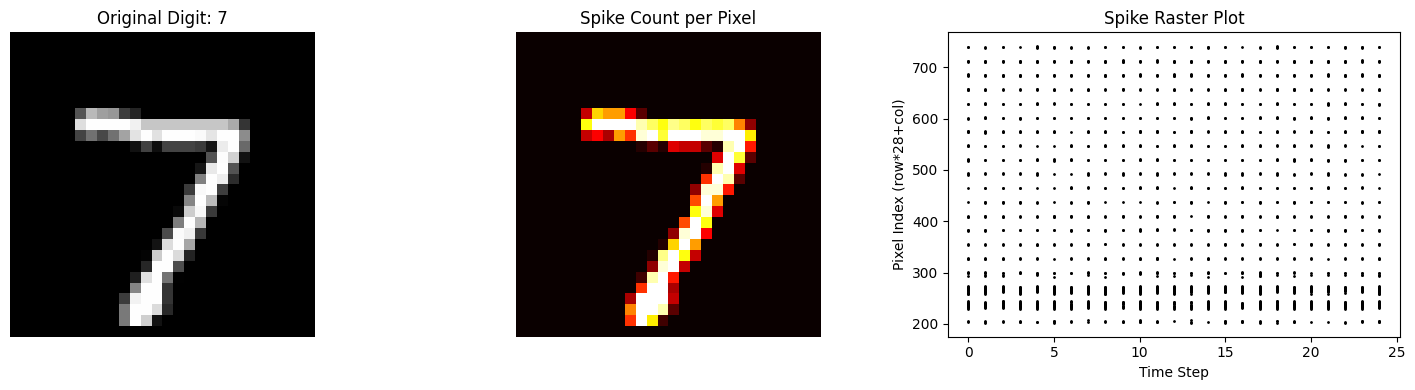

Visualizing spikes for sample index: 1


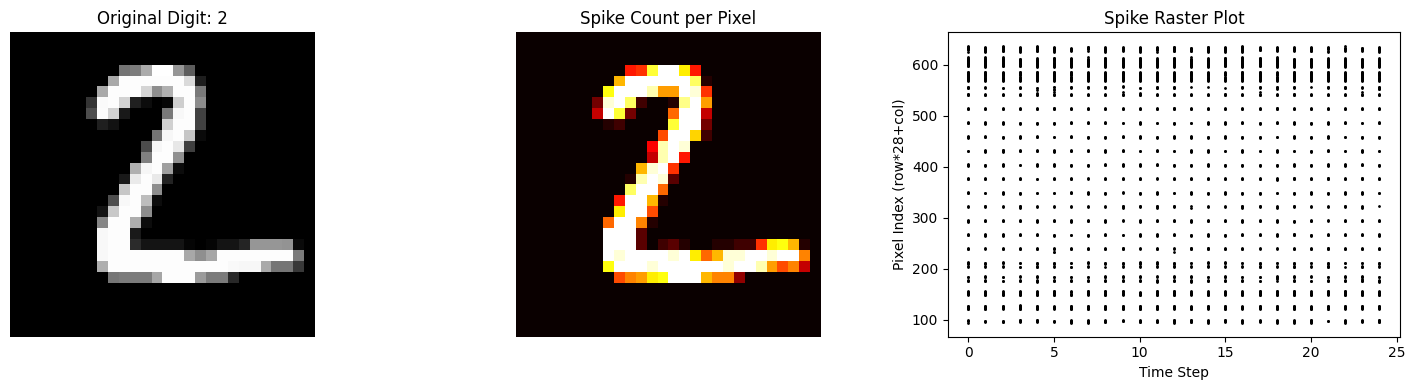

Visualizing spikes for sample index: 2


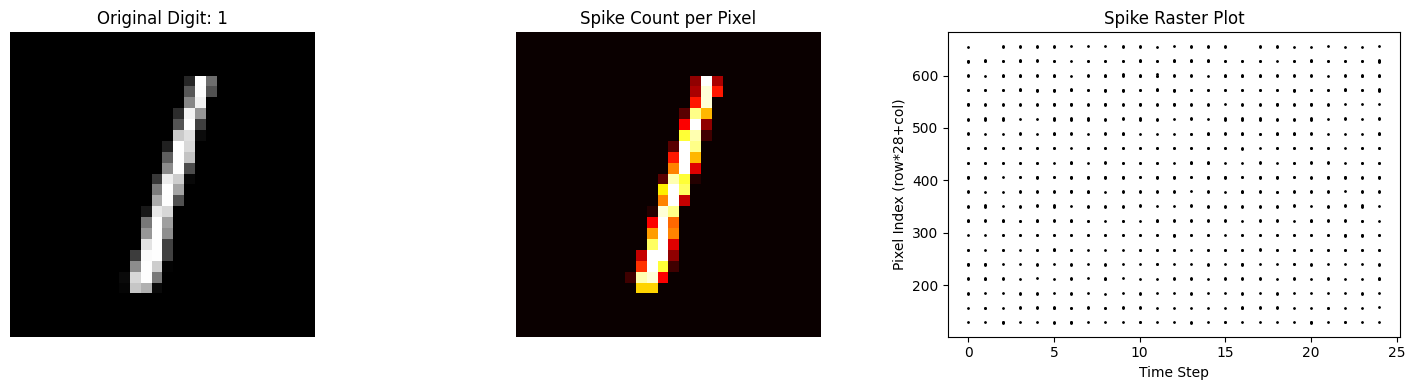

Visualizing spikes for sample index: 3


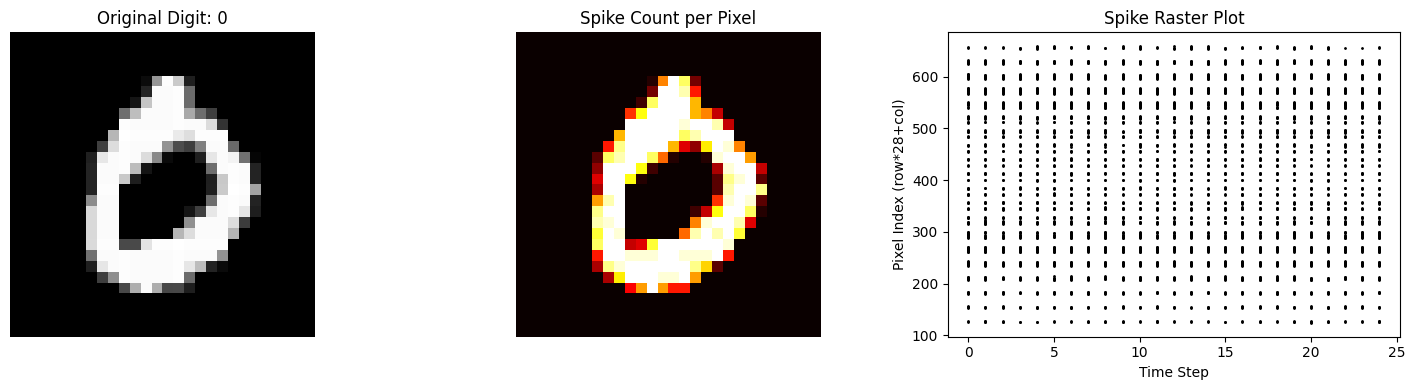

Visualizing spikes for sample index: 4


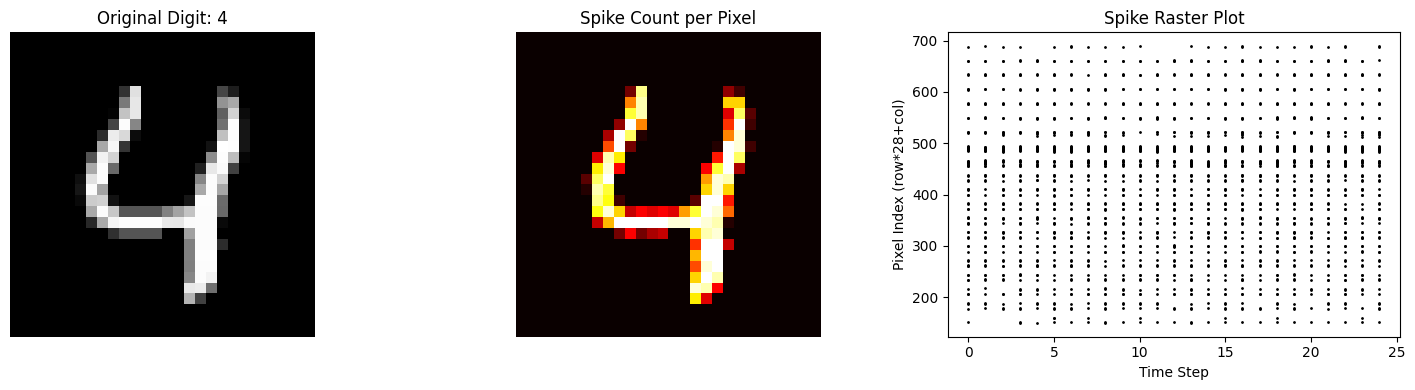

Visualizing spikes for sample index: 5


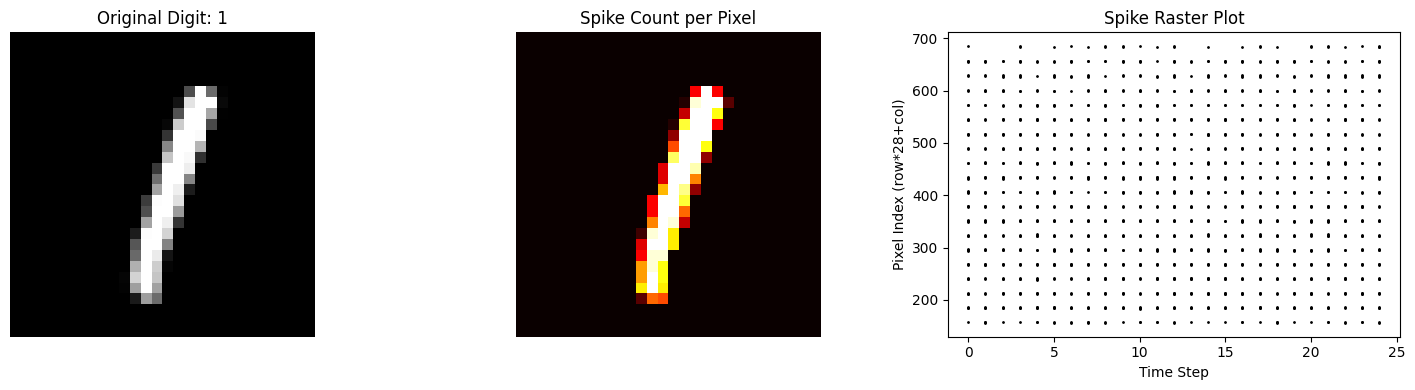

Visualizing spikes for sample index: 6


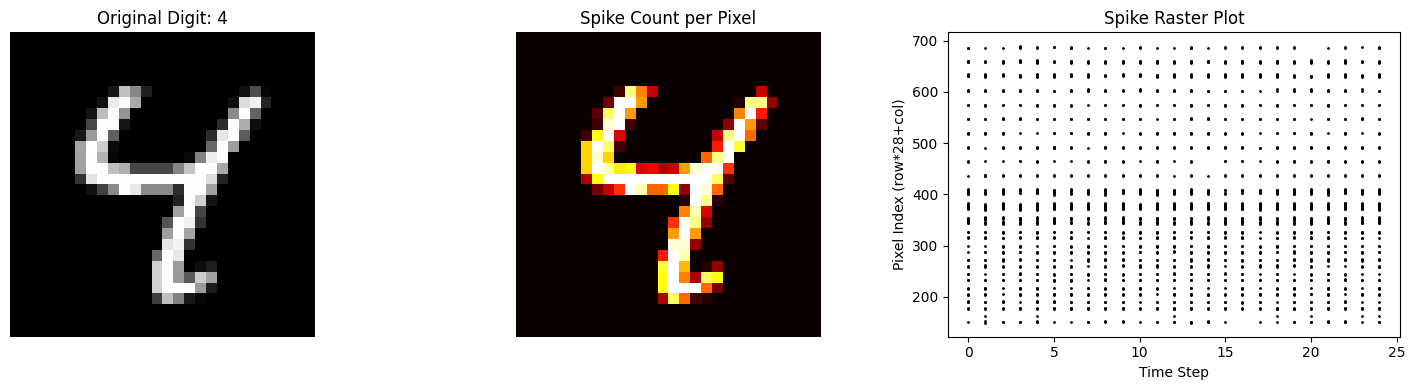

Visualizing spikes for sample index: 7


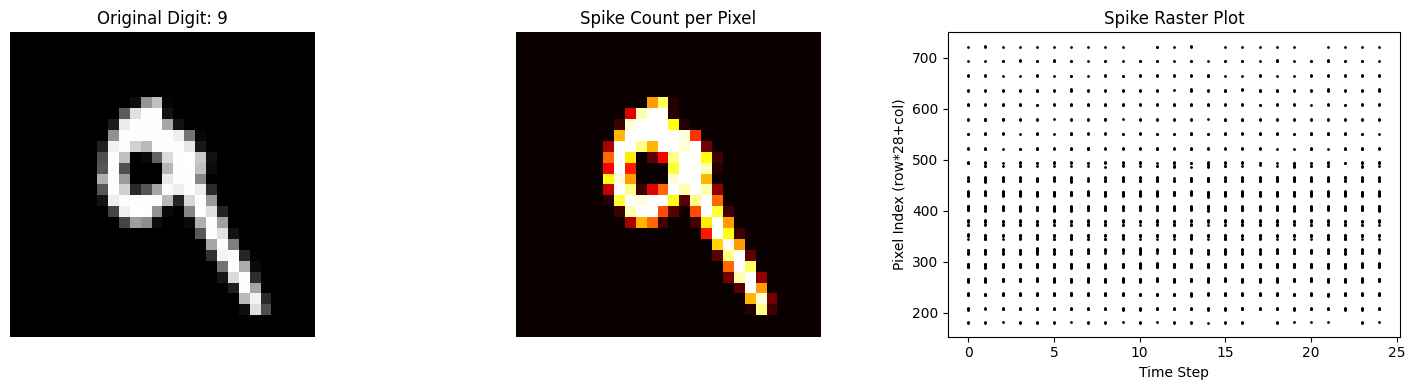

Visualizing spikes for sample index: 8


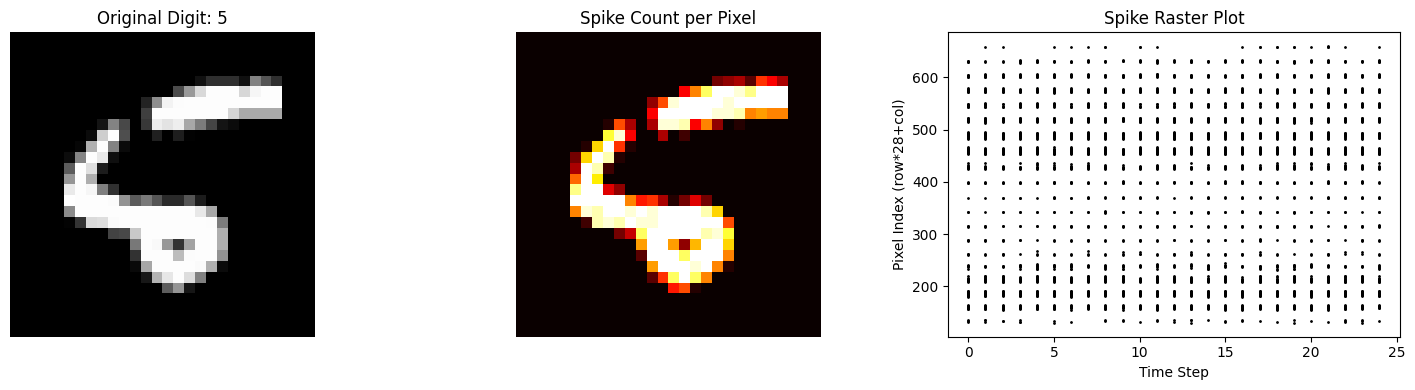

Visualizing spikes for sample index: 9


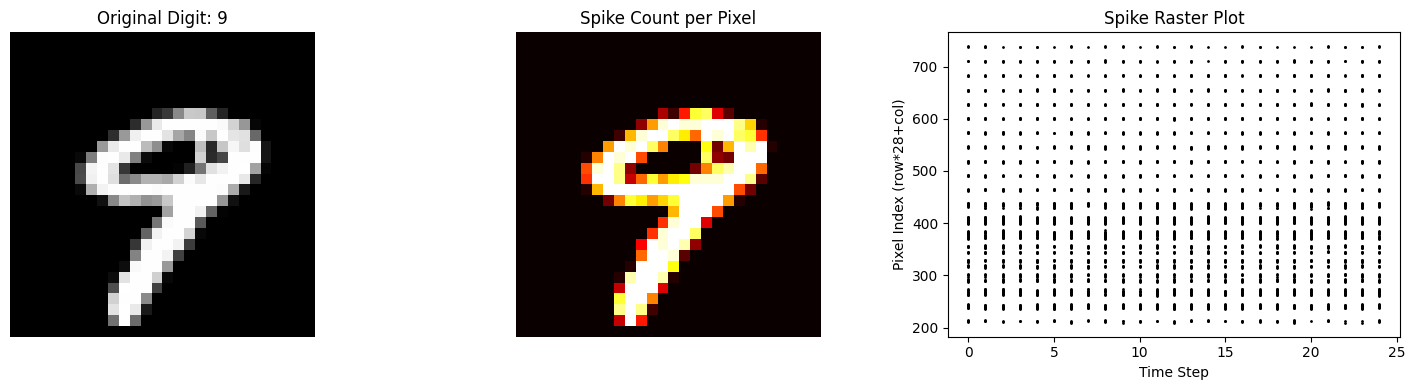

In [151]:
def visualize_spikes(idx):
    sample_img, label = testset[idx]
    sample_img = sample_img.to(device).unsqueeze(0)
    spikes = poisson_encode(sample_img, num_steps, device)  # (num_steps, 1, 784)

    plt.figure(figsize=(15, 4))

    # Show original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img.cpu().squeeze().numpy(), cmap='gray')
    plt.title(f"Original Digit: {label}")
    plt.axis('off')

    # Show spike sum image (total spikes per pixel)
    spike_img = spikes[:, 0, :].sum(dim=0).cpu().numpy().reshape(28, 28)
    plt.subplot(1, 3, 2)
    plt.imshow(spike_img, cmap='hot')
    plt.title("Spike Count per Pixel")
    plt.axis('off')

    # Raster plot: each dot is a spike for a pixel at a time step
    plt.subplot(1, 3, 3)
    spike_times, pixel_indices = spikes[:, 0, :].nonzero(as_tuple=True)
    # Convert pixel_indices to (row, col) for better visualization
    rows = (pixel_indices // 28).cpu().numpy()
    cols = (pixel_indices % 28).cpu().numpy()
    plt.scatter(spike_times.cpu(), rows * 28 + cols, s=1, color='black')
    plt.xlabel('Time Step')
    plt.ylabel('Pixel Index (row*28+col)')
    plt.title('Spike Raster Plot')
    plt.tight_layout()
    plt.show()

# Visualize spikes for each digit in sample_indices
for idx in sample_indices:
    print(f"Visualizing spikes for sample index: {idx}")
    visualize_spikes(idx)

Plots of pixel-wise spike histogram for digits 0-9

Plotting pixel-wise spike histogram for digit 0 (testset idx=3)


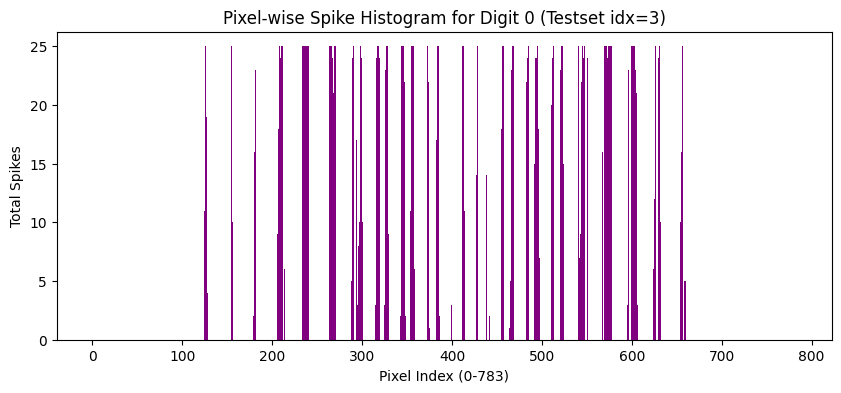

Plotting pixel-wise spike histogram for digit 1 (testset idx=2)


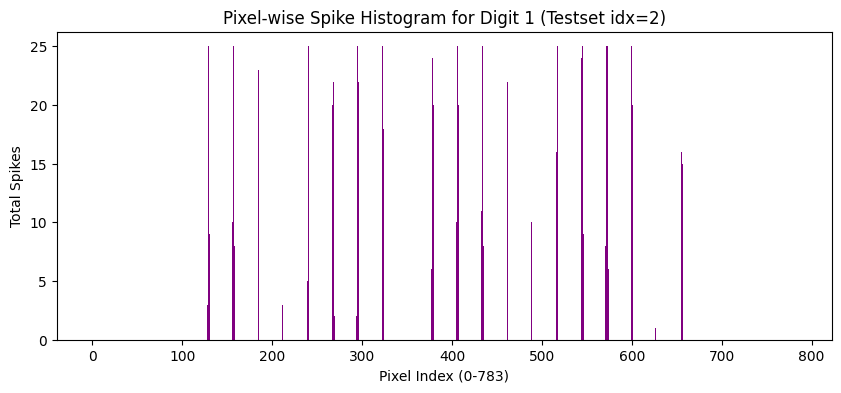

Plotting pixel-wise spike histogram for digit 2 (testset idx=1)


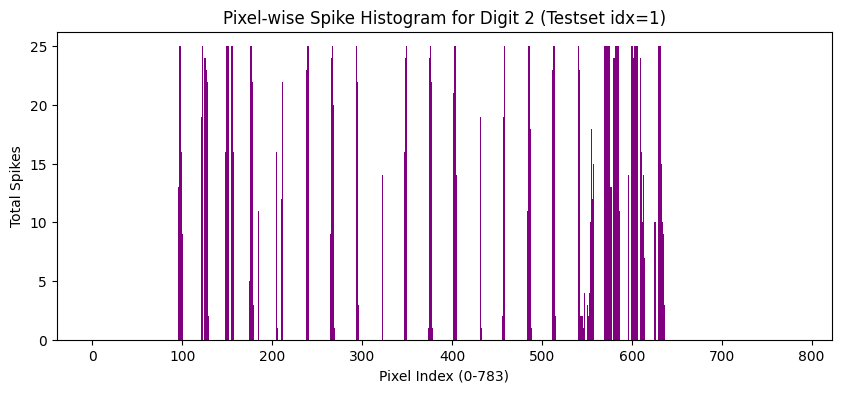

Plotting pixel-wise spike histogram for digit 3 (testset idx=18)


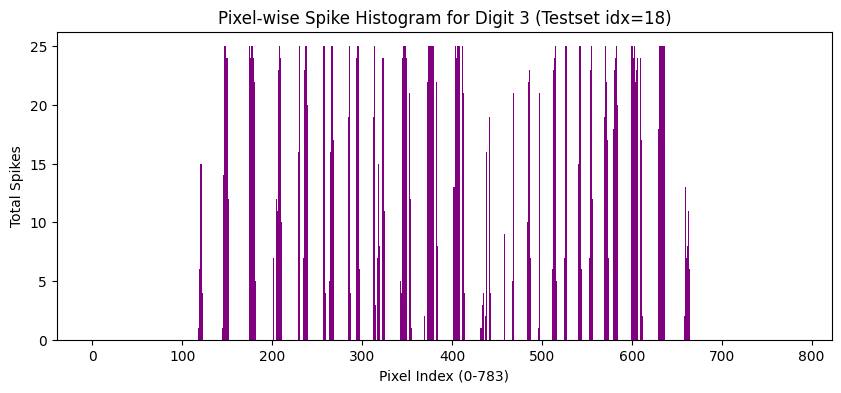

Plotting pixel-wise spike histogram for digit 4 (testset idx=4)


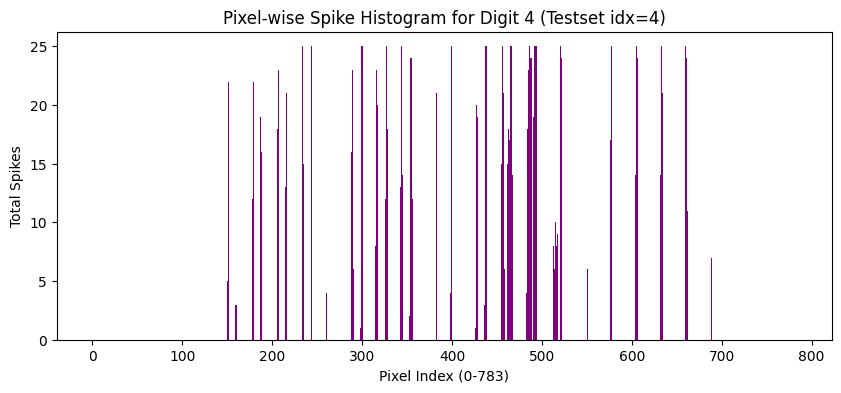

Plotting pixel-wise spike histogram for digit 5 (testset idx=8)


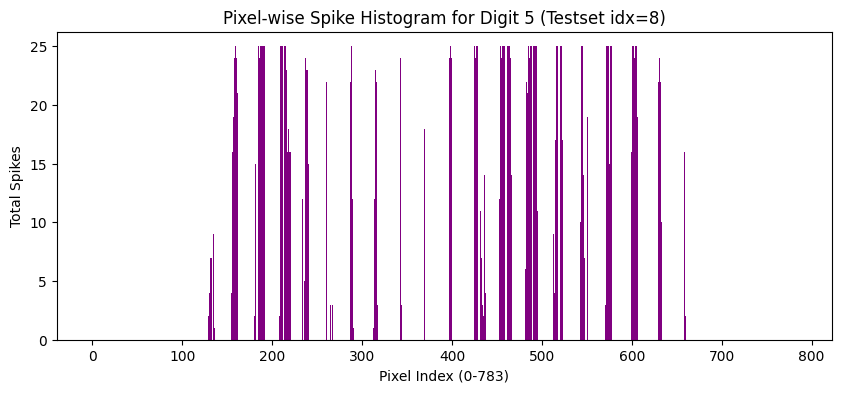

Plotting pixel-wise spike histogram for digit 6 (testset idx=11)


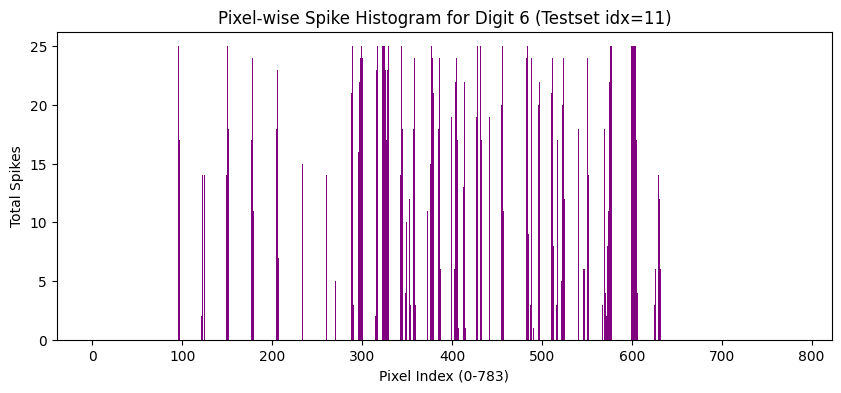

Plotting pixel-wise spike histogram for digit 7 (testset idx=0)


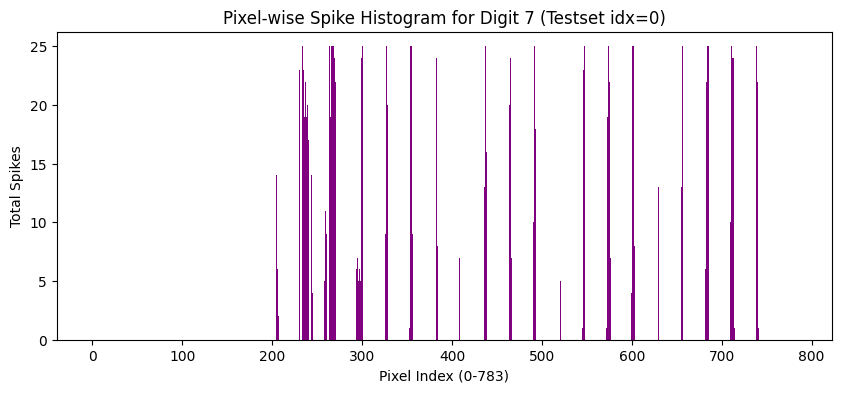

Plotting pixel-wise spike histogram for digit 8 (testset idx=61)


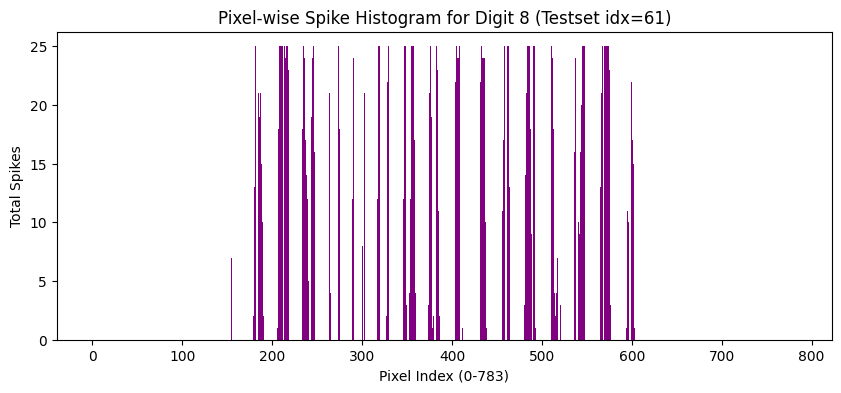

Plotting pixel-wise spike histogram for digit 9 (testset idx=7)


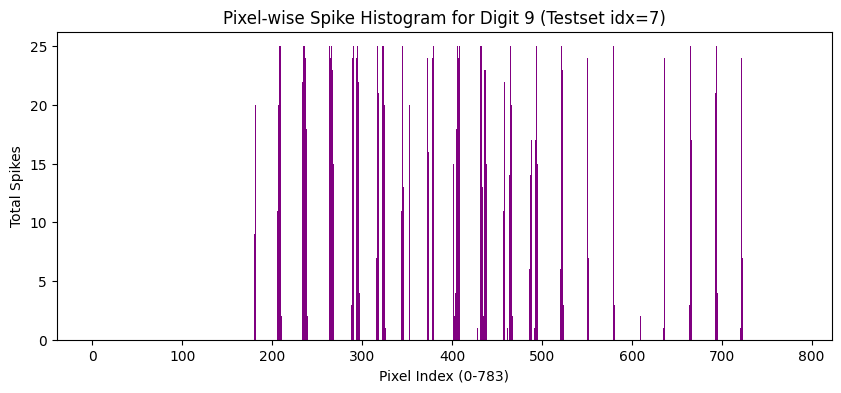

In [152]:
def plot_pixel_spike_histogram(idx):
    sample_img, label = testset[idx]
    sample_img = sample_img.to(device).unsqueeze(0)
    spikes = poisson_encode(sample_img, num_steps, device) 
    spike_counts = spikes[:, 0, :].sum(dim=0).cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.bar(range(784), spike_counts, color='purple')
    plt.xlabel('Pixel Index (0-783)')
    plt.ylabel('Total Spikes')
    plt.title(f'Pixel-wise Spike Histogram for Digit {label} (Testset idx={idx})')
    plt.show()

# Find and plot for one sample of each digit 0-9
for digit in range(10):
    for idx, (img, label) in enumerate(testset):
        if label == digit:
            print(f"Plotting pixel-wise spike histogram for digit {digit} (testset idx={idx})")
            plot_pixel_spike_histogram(idx)
            break